In [155]:
import os, math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.rcsetup
import matplotlib.image as mpimg
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 12.0)

In [208]:
def pipeline(img, show=False):#, mtx, dist, show=False):
    
    #So we don't have to pass for every frame of moviepy
    mtx = mtx_0
    dist = dist_0
    
    corners = corners_roi(img)
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    warped_img = warp_lane_lines(undist_img, corners)
    yellow_white_mask = color_mask(warped_img)
    masked_img = apply_mask(warped_img, yellow_white_mask)
    #TODO: Polynomial fit
    poly_img = polynomial_fit(masked_img)
    #TODO: Final image
    unwarped_lanes = warp_lane_lines(poly_img, corners, reverse=True)
    final_img = cv2.addWeighted(undist_img, 1, unwarped_lanes, 1, 0)
    if show:
        print(masked_img.dtype, masked_img.shape)
        print(poly_img.dtype, poly_img.shape)
        ax1 = plt.subplot(3, 2, 1)
        ax1.set_title('Original image')
        plt.imshow(img)
        ax2 = plt.subplot(3, 2, 2)
        ax2.set_title('Undistorted')
        plt.imshow(undist_img)
        ax3 = plt.subplot(3, 2, 3)
        ax3.set_title('Warped image')
        plt.imshow(warped_img)
        ax4 = plt.subplot(3, 2, 4)
        ax4.set_title('Masked image')
        plt.imshow(masked_img)
        ax5 = plt.subplot(3, 2, 5)
        ax5.set_title('Polynomial fit')
        plt.imshow(poly_img)
        ax6 = plt.subplot(3, 2, 6)
        ax6.set_title('Final image')
        plt.imshow(final_img)
        plt.tight_layout()
        plt.show()
    return final_img

In [157]:
def chessboard_calibrate(chess_w, chess_l, show=False):
    chess_counter = 0
    obj_pts = []
    img_pts = []
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.001)
    obj_corners = np.zeros((chess_w*chess_l, 3), np.float32)
    obj_corners[:,:2] = np.mgrid[0:chess_w,0:chess_l].T.reshape(-1,2)
    
    #Find chessboard corners and plot distorted chessboards
    cal_files = os.listdir(os.path.join(os.getcwd(), 'camera_cal'))
    cal_files.sort()
    fig_dist   = plt.figure(figsize=(15,12))
    for i, cal_file in enumerate(cal_files):
        cal_img = mpimg.imread(os.path.join(os.getcwd(), 'camera_cal', cal_file))
        gray_cal = cv2.cvtColor(cal_img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray_cal, (chess_w, chess_l), None)
        if ret == True:
            chess_counter += 1
            obj_pts.append(obj_corners)
            corners_2 = cv2.cornerSubPix(gray_cal, corners, (11,11), (-1,-1), criteria)
            img_pts.append(corners_2)
            cal_img = cv2.drawChessboardCorners(cal_img, (chess_w, chess_l), corners_2, ret)
            ax = plt.subplot(5, 4, i+1)
            ax.set_title(cal_file)
            plt.imshow(cal_img)
    
    print('Found {0} {1}x{2} chessboards in {3} images'.format(chess_counter,
                                                              chess_w,
                                                              chess_l,
                                                              i + 1))
    #Compute calibration matrices from object and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_pts, img_pts, cal_img.shape[:-1], None, None)
    
    #Undistort chessboards and plot undistorted chessboards
    fig_undist = plt.figure(figsize=(15,12))
    for i, cal_file in enumerate(cal_files):
        cal_img = mpimg.imread(os.path.join(os.getcwd(), 'camera_cal', cal_file))
        dst = cv2.undistort(cal_img, mtx, dist, None, mtx)
        ax = plt.subplot(5, 4, i+1)
        ax.set_title('corrected_{0}'.format(cal_file))
        plt.imshow(dst)
    
    if show:
        plt.show()

    return mtx, dist

In [195]:
def corners_roi(img, x_min=0.05, x_max=0.45, y_min=0.625, y_max=0.95):
    '''Slice out Region of Interest'''
    height = img.shape[0]
    width = img.shape[1]
    corners = np.array([[[    x_min*width, y_max*height],
                         [(1-x_min)*width, y_max*height],
                         [(1-x_max)*width, y_min*height],
                         [    x_max*width, y_min*height]]], dtype='int32')
    return corners

In [163]:
def warp_lane_lines(img, corners, reverse=False):
    src = np.float32(corners)
    dst = np.float32([[0, 720], [1280, 720], [1280, 0], [0, 0]])
    if reverse:
        M = cv2.getPerspectiveTransform(dst, src)
        return cv2.warpPerspective(img, M, img.shape[1::-1], 
                                   flags=cv2.INTER_LINEAR)
    else:
        M = cv2.getPerspectiveTransform(src, dst)
        return cv2.warpPerspective(img, M, img.shape[1::-1], 
                                   flags=cv2.INTER_LINEAR)

In [160]:
def color_mask(img):
    '''Creates a mask that shows yellow and white lane colors'''
    #Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = 0.75*gray #darken grayscale
    
    #Convert to HSV, take out yellow. Add white to gray image,
    #where yellow and white exists to increase contrast
    low_y = np.array([70,0,100])
    high_y = np.array([110,255,255])
    low_w = np.array([0,0,180])
    high_w = np.array([255,32,255])
        
    hue = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    y_mask = cv2.inRange(hue, low_y, high_y)
#     y_mask = cv2.dilate(y_mask, (3,3), iterations=10)
    
    w_mask = cv2.inRange(hue, low_w, high_w)
#     w_mask = cv2.dilate(w_mask, (3,3), iterations=10)
    
    two_masks = cv2.bitwise_or(w_mask, y_mask)
    two_masks_inv = cv2.bitwise_not(two_masks)
    return two_masks

In [10]:
def apply_mask(img, mask):
    return cv2.bitwise_and(img, img, mask=mask)

In [191]:
def polynomial_fit(img, show=False):
    '''Given a warped image return a polynomial that 
       describes the curvature of the lane line'''
    # Useful variables
    left_lane = LaneLine()
    right_lane = LaneLine()
    grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    height, width = grey_img.shape
    midpoint = np.int(width / 2)
    n_windows = 9
    window_height = np.int(height / n_windows)

    # Create binary image from img
    binary_img = np.zeros_like(grey_img)
    binary_img[grey_img > 0] = 1
    out_img = np.dstack((binary_img, binary_img, binary_img))#*255
    
    # Create histogram to find start of lane lines
    histogram = np.sum(binary_img[height//2:,:], axis=0)
    left_x_base = np.argmax(histogram[:midpoint])
    right_x_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Identify x,y positions of all nonzero pixels in the image
    nonzero = binary_img.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    
    left_x_current = left_x_base
    right_x_current = right_x_base
    margin = 100
    min_pix = 50
    
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(n_windows):
        win_y_low = height - (window + 1)*window_height
        win_y_high = height - window*window_height
        win_x_left_low   = left_x_current  - margin
        win_x_left_high  = left_x_current  + margin
        win_x_right_low  = right_x_current - margin
        win_x_right_high = right_x_current + margin
        cv2.rectangle(out_img,(win_x_left_low,  win_y_low), 
                              (win_x_left_high, win_y_high), 
                              (0, 1.0, 0), 5) 
        cv2.rectangle(out_img,(win_x_right_low, win_y_low),
                              (win_x_right_high,win_y_high),
                              (0, 1.0, 0), 5) 
        good_left_inds =  ((nonzero_y >= win_y_low) &
                           (nonzero_y <  win_y_high) &
                           (nonzero_x >= win_x_left_low) &
                           (nonzero_x <  win_x_left_high)).nonzero()[0]
        good_right_inds = ((nonzero_y >= win_y_low) &
                           (nonzero_y <  win_y_high) &
                           (nonzero_x >= win_x_right_low) &
                           (nonzero_x <  win_x_right_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > min_pix:
            left_x_current = np.int(np.mean(nonzero_x[good_left_inds]))
        if len(good_right_inds) > min_pix:
            right_x_current = np.int(np.mean(nonzero_x[good_right_inds]))
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    left_x  = nonzero_x[left_lane_inds]
    left_y  = nonzero_y[left_lane_inds] 
    right_x = nonzero_x[right_lane_inds]
    right_y = nonzero_y[right_lane_inds]
    
    plot_y = np.linspace(0, height-1, height)
    overlay_l = np.copy(img)
    overlay_r = np.copy(img)
    overlay_c = np.copy(img)
    poly_img = np.copy(img)
    if left_x.sum() > 0  and left_y.sum() > 0:
        left_fit = np.polyfit(left_y, left_x, 2)
        left_fit_x = left_fit[0]*plot_y**2 + left_fit[1]*plot_y + left_fit[2]
        pts_l = np.column_stack((left_fit_x, plot_y)).astype(np.int32)
        cv2.polylines(overlay_l, [pts_l], False, (255, 0, 0), thickness=100, lineType=cv2.LINE_AA)
    else:
        print('No fit found, because no pixels found on left side')
        left_fit = None
        left_fit_x = None
        show = False
        
    if right_x.sum() > 0 and right_y.sum() > 0:
        right_fit = np.polyfit(right_y, right_x, 2)
        right_fit_x = right_fit[0]*plot_y**2 + right_fit[1]*plot_y + right_fit[2]
        pts_r = np.column_stack((right_fit_x, plot_y)).astype(np.int32)
        cv2.polylines(overlay_r, [pts_r], False, (0, 0, 255), thickness=100, lineType=cv2.LINE_AA)
    else:
        print('No fit found, because no pixels found on right side')
        right_fit = None
        right_fit_x = None
        show = False
    pts = np.concatenate((pts_l, pts_r[::-1]))
    cv2.fillPoly(overlay_c, np.int_([pts]), (0,255, 0))
    alpha = 0.5
    poly_img = cv2.addWeighted(overlay_l, alpha, poly_img, 1, 0)
    poly_img = cv2.addWeighted(overlay_r, alpha, poly_img, 1, 0)
    poly_img = cv2.addWeighted(overlay_c, alpha, poly_img, 1, 0)
    left_rad  = radius_curvature(left_fit_x,  plot_y)
    right_rad = radius_curvature(right_fit_x, plot_y)
    
    if show:
        print('Left Lane line  {0:.02}y^2 + {1:.02}y + {2:.02}'.format(left_fit[0], 
                                                                   left_fit[1],
                                                                   left_fit[2]))
        print('Left lane radius of curvature {0:.02} m'.format(left_rad))
        
        print('Right Lane line {0:.02}y^2 + {1:.02}y + {2:.02}'.format(right_fit[0], 
                                                                       right_fit[1],
                                                                       right_fit[2]))
        print('Right lane radius of curvature {0:.02} m'.format(right_rad))
        plt.imshow(poly_img)
#         plt.plot(left_fit_x,  plot_y, color='yellow')
#         plt.plot(right_fit_x, plot_y, color='yellow')
        
    return poly_img

In [190]:

a = np.linspace(0,9,10)
a[::-1]

array([ 9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.,  0.])

In [70]:
def radius_curvature(x, y):
    y_scale = 30/720
    x_scale = 3.7/700
    
    x_fit = np.polyfit(y*y_scale, x*x_scale, 2)
    return ((1 + (2*x[0]*np.max(y)*y_scale + x[1])**2)**1.5) / np.absolute(2*x[0])

In [3]:
# Define a class to receive the characteristics of each line detection
class LaneLine():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_x_fitted = [] 
        #average x values of the fitted line over the last n iterations
        self.best_x = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.all_x = None  
        #y values for detected line pixels
        self.all_y = None

Found 17 9x6 chessboards in 20 images


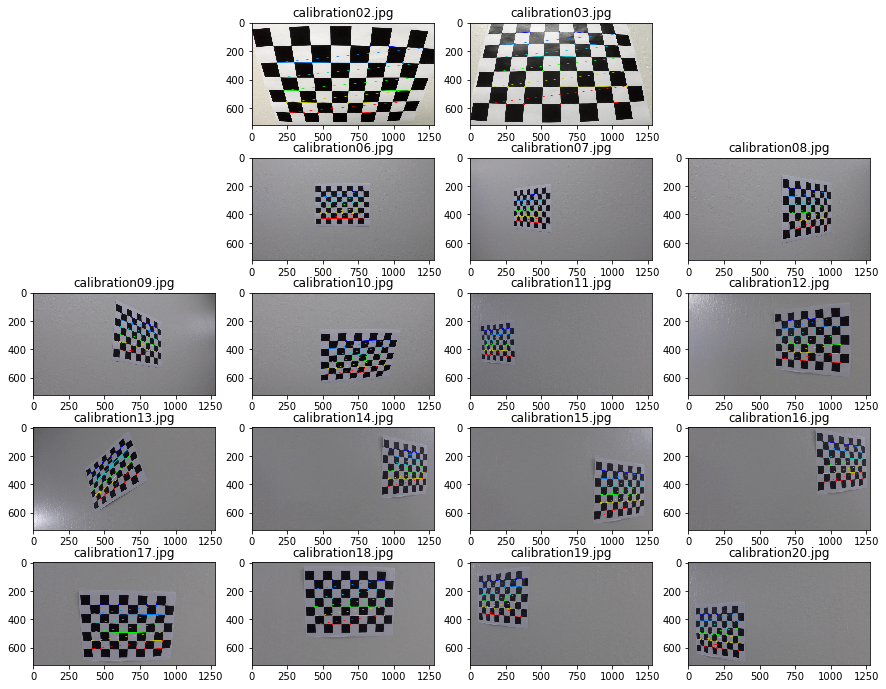

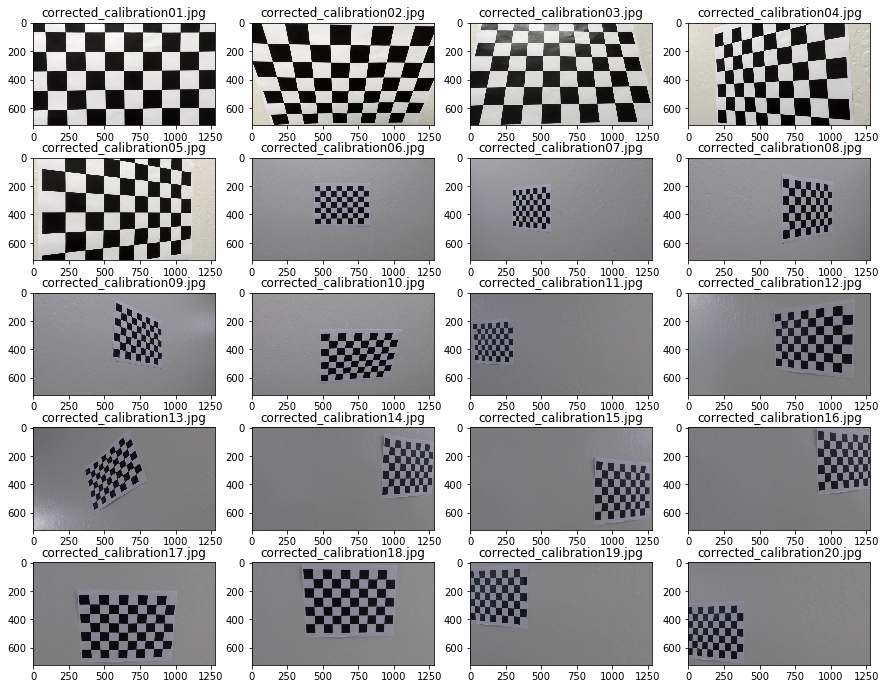

Found 1 9x5 chessboards in 20 images
Found 2 8x6 chessboards in 20 images


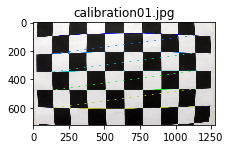

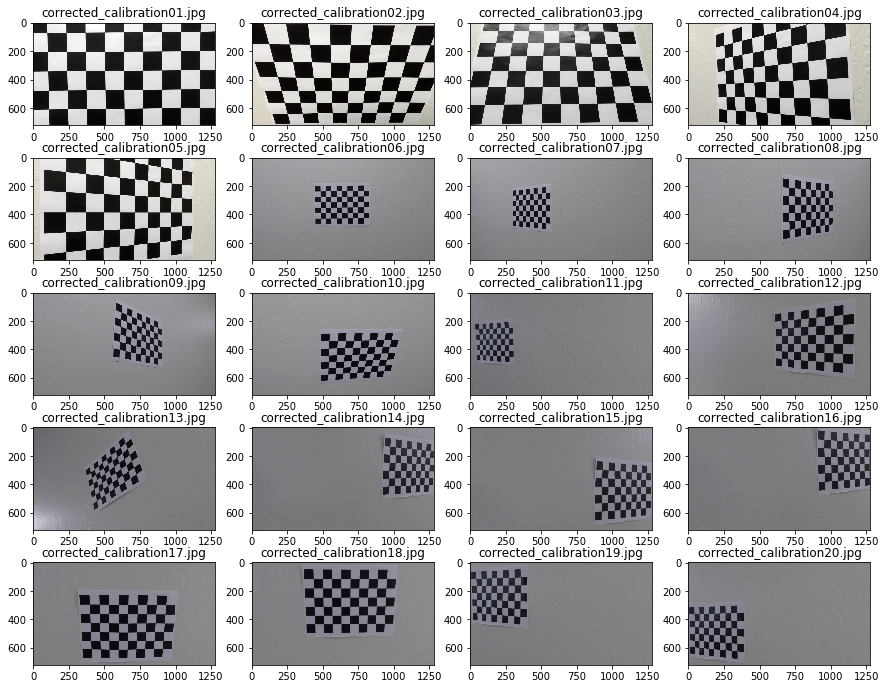

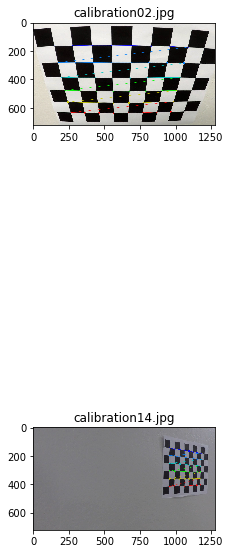

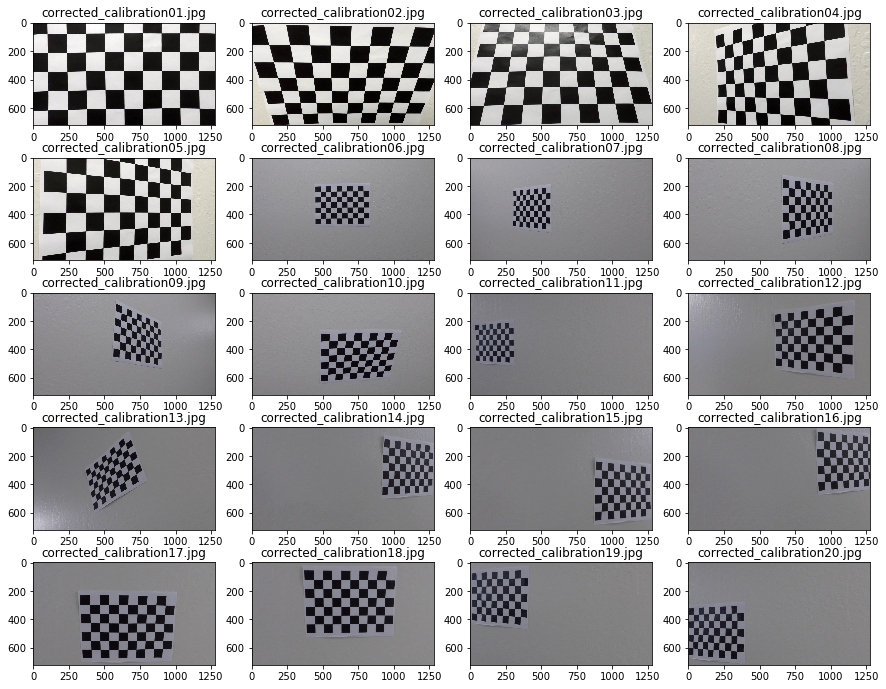

In [43]:
mtx_0, dist_0 = chessboard_calibrate(9, 6, show=True)
mtx_1, dist_1 = chessboard_calibrate(9, 5, show=False)
mtx_2, dist_2 = chessboard_calibrate(8, 6, show=False)

In [207]:
straight_img = mpimg.imread('./test_images/straight_lines1.jpg')
straight_img_2 = mpimg.imread('./test_images/straight_lines2.jpg')

img = straight_img_2
final = pipeline(img, show=True)#, mtx_0, dist_0, show=True)

TypeError: pipeline() missing 2 required positional arguments: 'mtx' and 'dist'

In [202]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip, TextClip, CompositeVideoClip
from IPython.display import HTML

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.098304/28549024 bytes (0.3%557056/28549024 bytes (2.01032192/28549024 bytes (3.6%1622016/28549024 bytes (5.7%2260992/28549024 bytes (7.9%2908160/28549024 bytes (10.23604480/28549024 bytes (12.64325376/28549024 bytes (15.24980736/28549024 bytes (17.45619712/28549024 bytes (19.76225920/28549024 bytes (21.86864896/28549024 bytes (24.07536640/28549024 bytes (26.48159232/28549024 bytes (28.68732672/28549024 bytes (30.69469952/28549024 bytes (33.210092544/28549024 bytes (35.4%10715136/28549024 bytes (37.5%11534336/28549024 bytes (40.4%12132352/28549024 bytes (42.5%12959744/28549024 bytes (45.4%13574144/28549024 bytes (47.5%14229504/28549024 bytes (49.8%15015936/28549024 bytes (52.6%15327232/28549024 bytes (53.7%16048128/28549024 bytes (56.2%16785408/28549024 bytes (58.8%174

In [209]:
white_output = 'example.mp4'

# txt_clip = TextClip("Advanced Lanelines\nChris Sketch",font='Arial',fontsize=40,color='white')
# txt_clip = txt_clip.set_pos(('center', 'top')).set_duration(8)

clip1 = VideoFileClip('./project_video.mp4')
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!

video = CompositeVideoClip([white_clip])#, txt_clip])
%time video.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video example.mp4
[MoviePy] Writing video example.mp4


100%|█████████▉| 1260/1261 [05:22<00:00,  4.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: example.mp4 

CPU times: user 33min 36s, sys: 6.97 s, total: 33min 43s
Wall time: 5min 22s


In [210]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))